# Tagup Data Science Exercise

ExampleCo, Inc is gathering several types of data for its fleet of very expensive machines.  These very expensive machines have three operating modes: *normal*, *faulty* and *failed*.   The machines run all the time, and usually they are in normal mode.  However, in the event that the machine enters faulty mode, the company would like to be aware of this as soon as possible.  This way they can take preventative action to avoid entering failed mode and hopefully save themselves lots of money.

They collect four kinds of timeseries data for each machine in their fleet of very expensive machines.  When a machine is operating in *normal* mode the data behaves in a fairly predictable way, but with a moderate amount of noise.  Before a machine fails it will ramp into *faulty* mode, during which the data appears visibly quite different.  Finally, when a machine fails it enters a third, and distinctly different, *failed* mode where all signals are very close to 0.

You can download the data here: [exampleco_data](https://drive.google.com/open?id=1b12u6rzkG1AxB6wLGl7IBVoaoSoZLHNR)

__Your main objective: to develop an automated method to pinpoint the times of fault and failure in this machine__.  Keep in mind that you will be sharing these results with the executives at ExampleCo, so to the best of your ability, try to explain what you are doing, what you've shown, and why you think your predictions are good.


A few notes to help:
1. A good place to start is by addressing the noise due to communication
   errors.
2. Feel free to use any libraries you like. Your final results should be
   presented in this Python notebook.
3. There are no constraints on the techniques you bring to bear, we are curious
   to see how you think and what sort of resources you have in your toolbox.
4. Be sure to clearly articulate what you did, why you did it, and how the
   results should be interpreted. In particular you should be aware of the
   limitations of whatever approach or approaches you take.
5. Don't feel compelled to use all the data if you're not sure how. Feel free
   to focus on data from a single unit if that makes it easier to get started.
6. Don't hesitate to reach out to datasciencejobs@tagup.io with any questions!

In [2]:
# To help you get started...
from IPython.display import display
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime

plt.style.use('ggplot')

%matplotlib inline 

# Load Data

In [3]:
def load_data(machine_number):
    data = pd.read_csv('Data/machine_{}.csv'.format(machine_number))
    data['Unnamed: 0'] = pd.to_datetime(data['Unnamed: 0'])
    data = data.rename(columns = {'Unnamed: 0':'Time', '0': 'Feature 0','1': 'Feature 1', '2': 'Feature 2', '3': 'Feature 3'})
    return data 

machines = [load_data(i) for i in range(0, 20)]

# Exploratory Data Analysis

Are times between time points equal - can this be turned into an additional feature

Is the time period the same for each machine

What is the mean/ variance of each machine by Feature - might need to cleverly aggregate data for plotting

Is there any relation to days of the week

In [4]:
# look at data
machines[0].head(10)

,Time,Feature 0,Feature 1,Feature 2,Feature 3
0,2019-01-01 00:00:00.000000000,12.626096,8.803120,-11.809200,10.083961
1,2019-01-01 08:00:09.603201067,10.831994,2.816327,11.554778,21.892853
2,2019-01-01 16:00:19.206402134,21.083510,-0.672645,-17.839178,-1.349024
3,2019-01-02 00:00:28.809603201,32.294495,6.525132,-13.498586,-4.250752
4,2019-01-02 08:00:38.412804268,28.057100,3.691359,21.984744,13.670561
5,2019-01-02 16:00:48.016005335,29.646637,-3.522426,3.364964,-3.015832
6,2019-01-03 00:00:57.619206402,38.902674,1.916522,-10.849385,-17.702242
7,2019-01-03 08:01:07.222407469,33.052626,3.204629,25.474912,1.118645
8,2019-01-03 16:01:16.825608536,25.190551,-5.460431,22.956234,-3.472719
9,2019-01-04 00:01:26.428809603,29.554267,-3.325767,-5.842399,-25.124870


In [5]:
machines[0].describe()

,Feature 0,Feature 1,Feature 2,Feature 3
count,3000.000000,3000.000000,3000.000000,3000.000000
mean,-0.816016,-1.091308,1.267945,0.165844
std,58.078319,55.965665,56.538700,56.910659
min,-323.954437,-258.780879,-287.153920,-365.362164
25%,-0.008684,-0.008851,-0.008274,-0.007883
50%,-0.000402,-0.000085,0.000669,0.000310
75%,0.007832,0.008373,0.009056,0.008685
max,315.738951,264.374782,281.684102,340.513819


In [6]:
# Check length of data
print(len(machines[0]))
for machine in machines:
    assert len(machine) == len(machines[0])

# Check if timestamp are different
for i in range(0, len(machines) -1):
    assert all(machines[i]['Time'] == machines[i+1]['Time'])
# Each measurement is taken 3 times a day at intervals of just over 8 hours

3000


## Visualize Data 

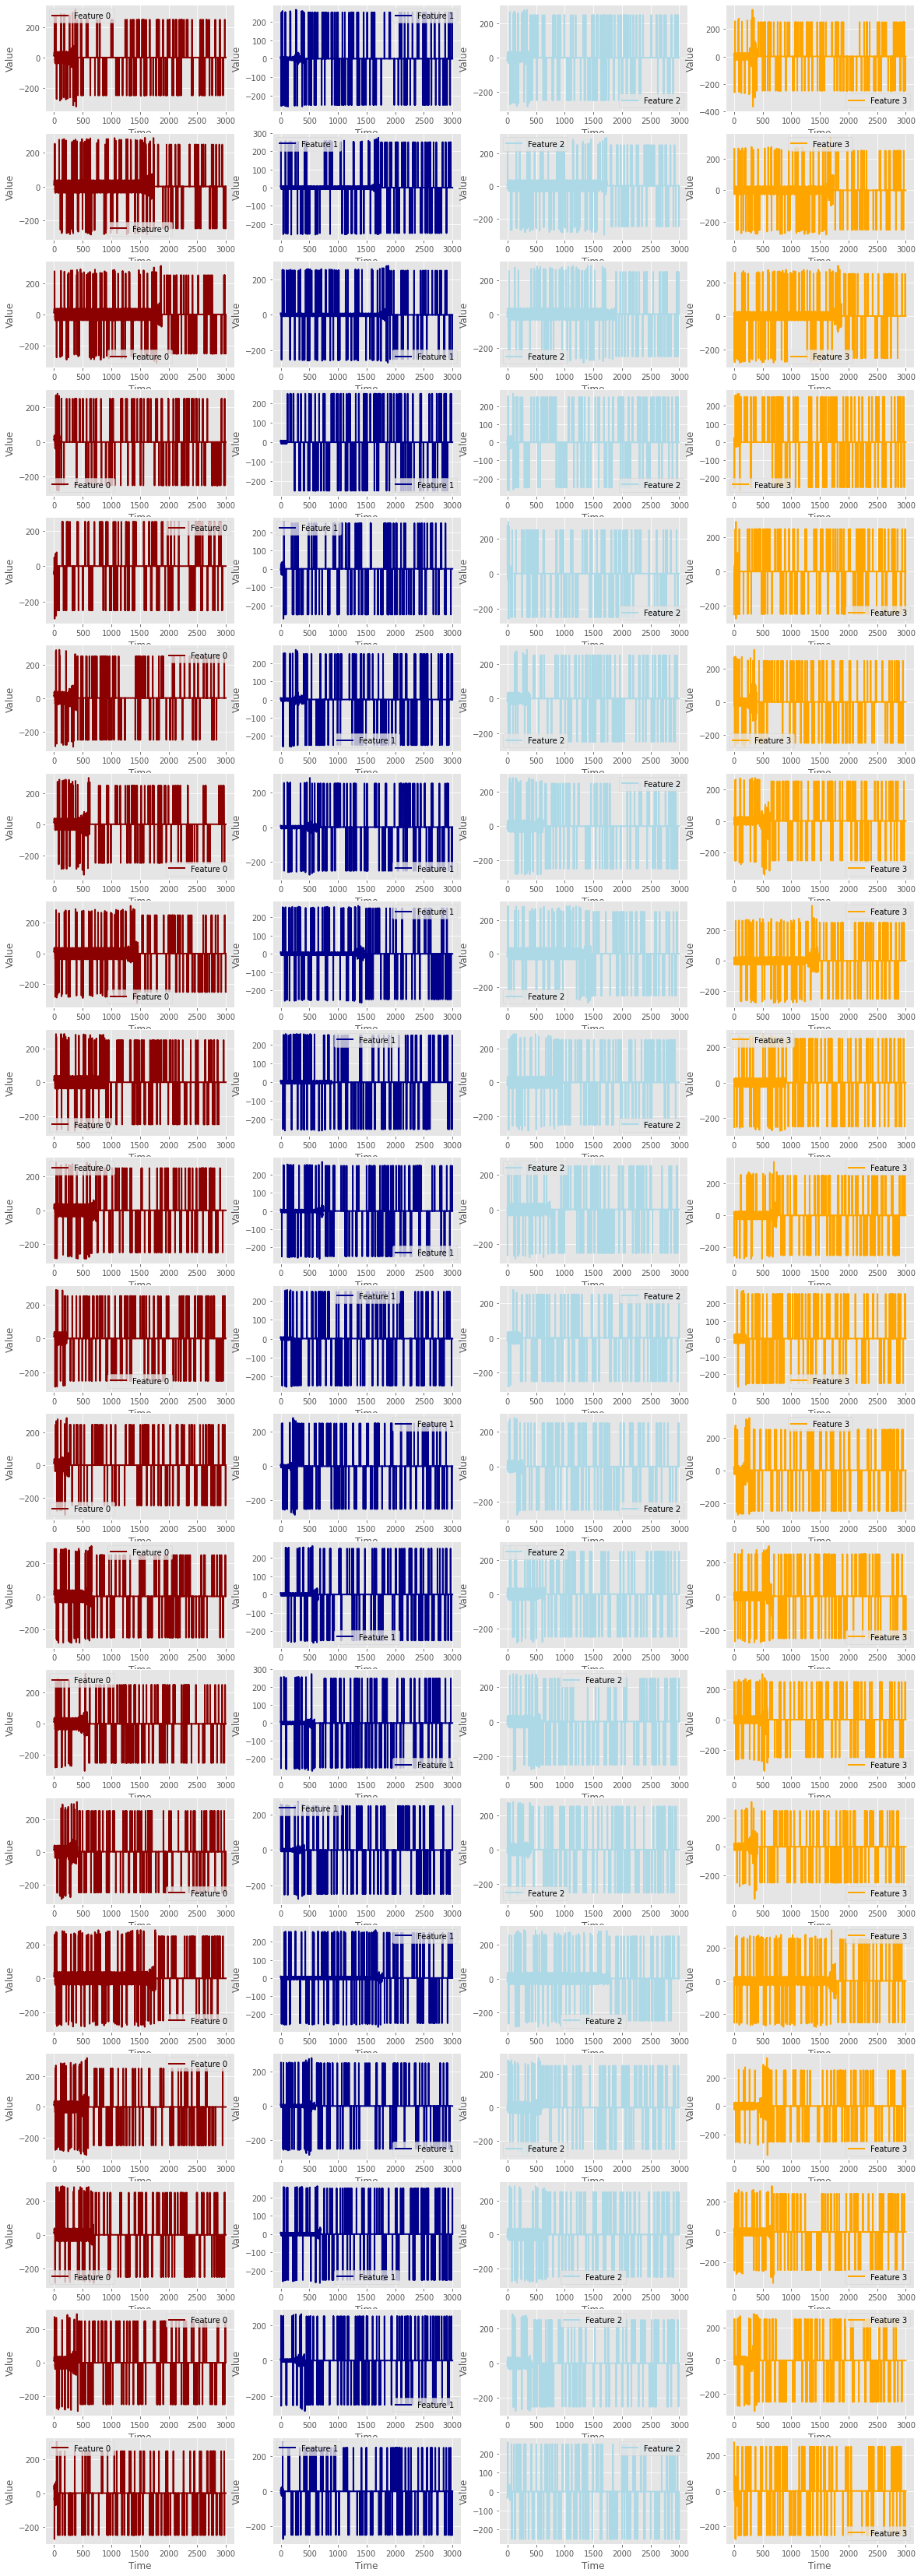

In [7]:
colors = {'0': 'darkred', '1': 'darkblue', '2': 'lightblue', '3': 'orange'}
def plot_feature(machine, feature, ax):
    ax.set_ylabel('Value')
    ax.set_xlabel('Time')
    sns.lineplot(data = machine['Feature {}'.format(feature)], ax = ax, label = 'Feature {}'.format(feature), color = colors[str(feature)], lw = 2)

# Plot all machines and features
rows = len(machines)
cols = 4
fig, ax = plt.subplots(rows, cols, figsize = (20, 60))
for i in range(0, rows):
    for j in range(0, cols):
        plot_feature(machines[i], j, ax[i, j])
fig.savefig('Figures/all_machines_time_series')

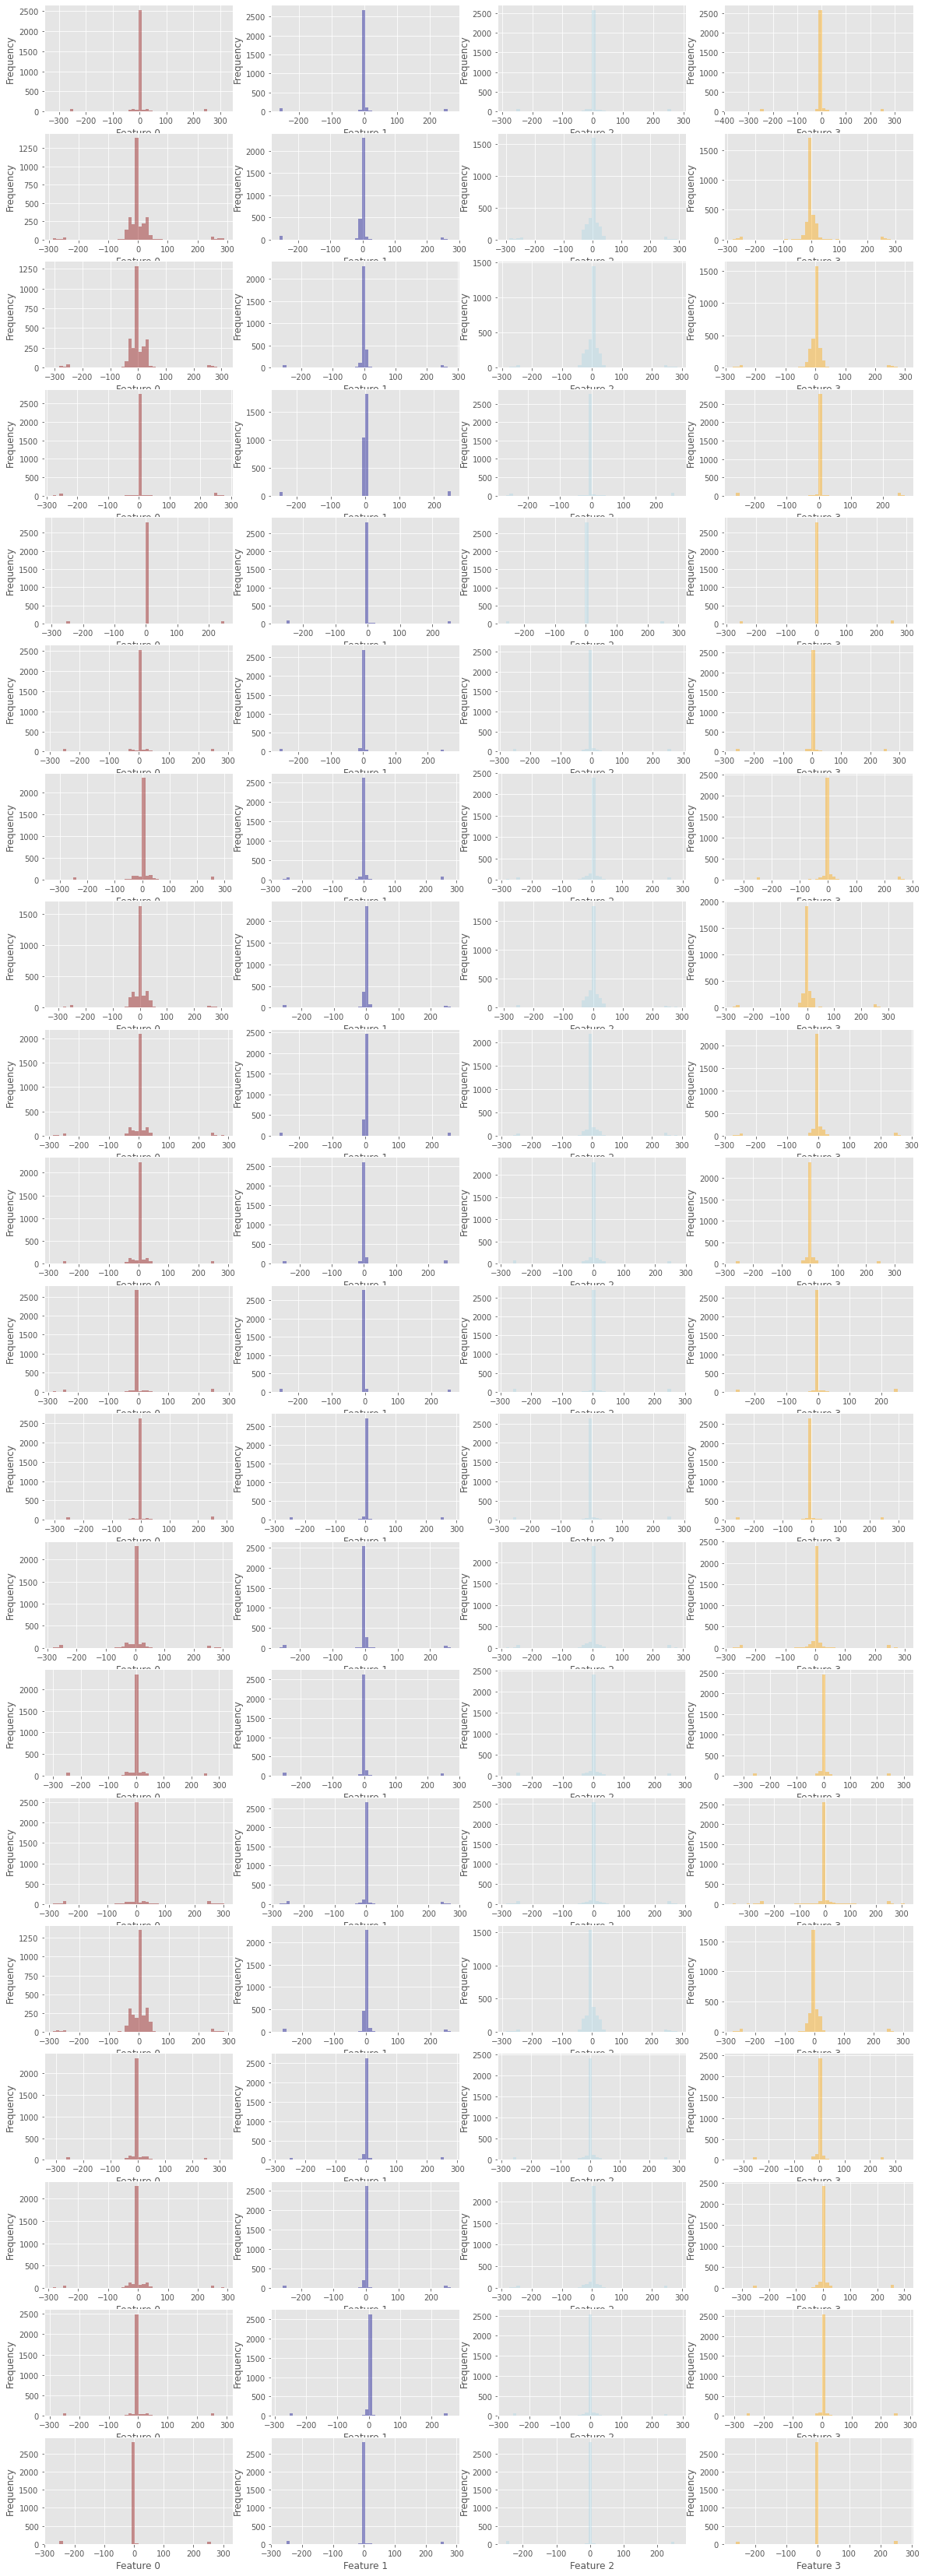

In [8]:
# Look at distributions of data 
def plot_feature_distributions(machine, feature, ax):
    ax.set_ylabel('Frequency')
    ax.set_xlabel('Value')
    sns.distplot(machine['Feature {}'.format(feature)], kde = False,  ax = ax, label = 'Feature {}'.format(feature), color = colors[str(feature)])

fig, ax = plt.subplots(rows, cols, figsize = (20, 60))
for i in range(0, rows):
    for j in range(0, cols):
        plot_feature_distributions(machines[i], j, ax[i, j])
fig.savefig('Figures/all_machines_distributions')


Look to be strong outliers at extreme positive and negative values which may be associated with communication errors.

These outliers also may have made potential relationships difficult to see on the above time series plots. 

Therefore we should evaluate what the data might look like after removing these outliers. 

## Outlier Removal

In [49]:
def remove_outliers(data):
    """Replace outliers with 0"""
    for i in range(0, 4):
        data.loc[(data['Feature {}'.format(i)] > 200)  | (data['Feature {}'.format(i)] < -200), 'Feature {}'.format(i)] = 0

for i in range(0, len(machines)):
    remove_outliers(machines[i])

## Replot with Outliers Removed

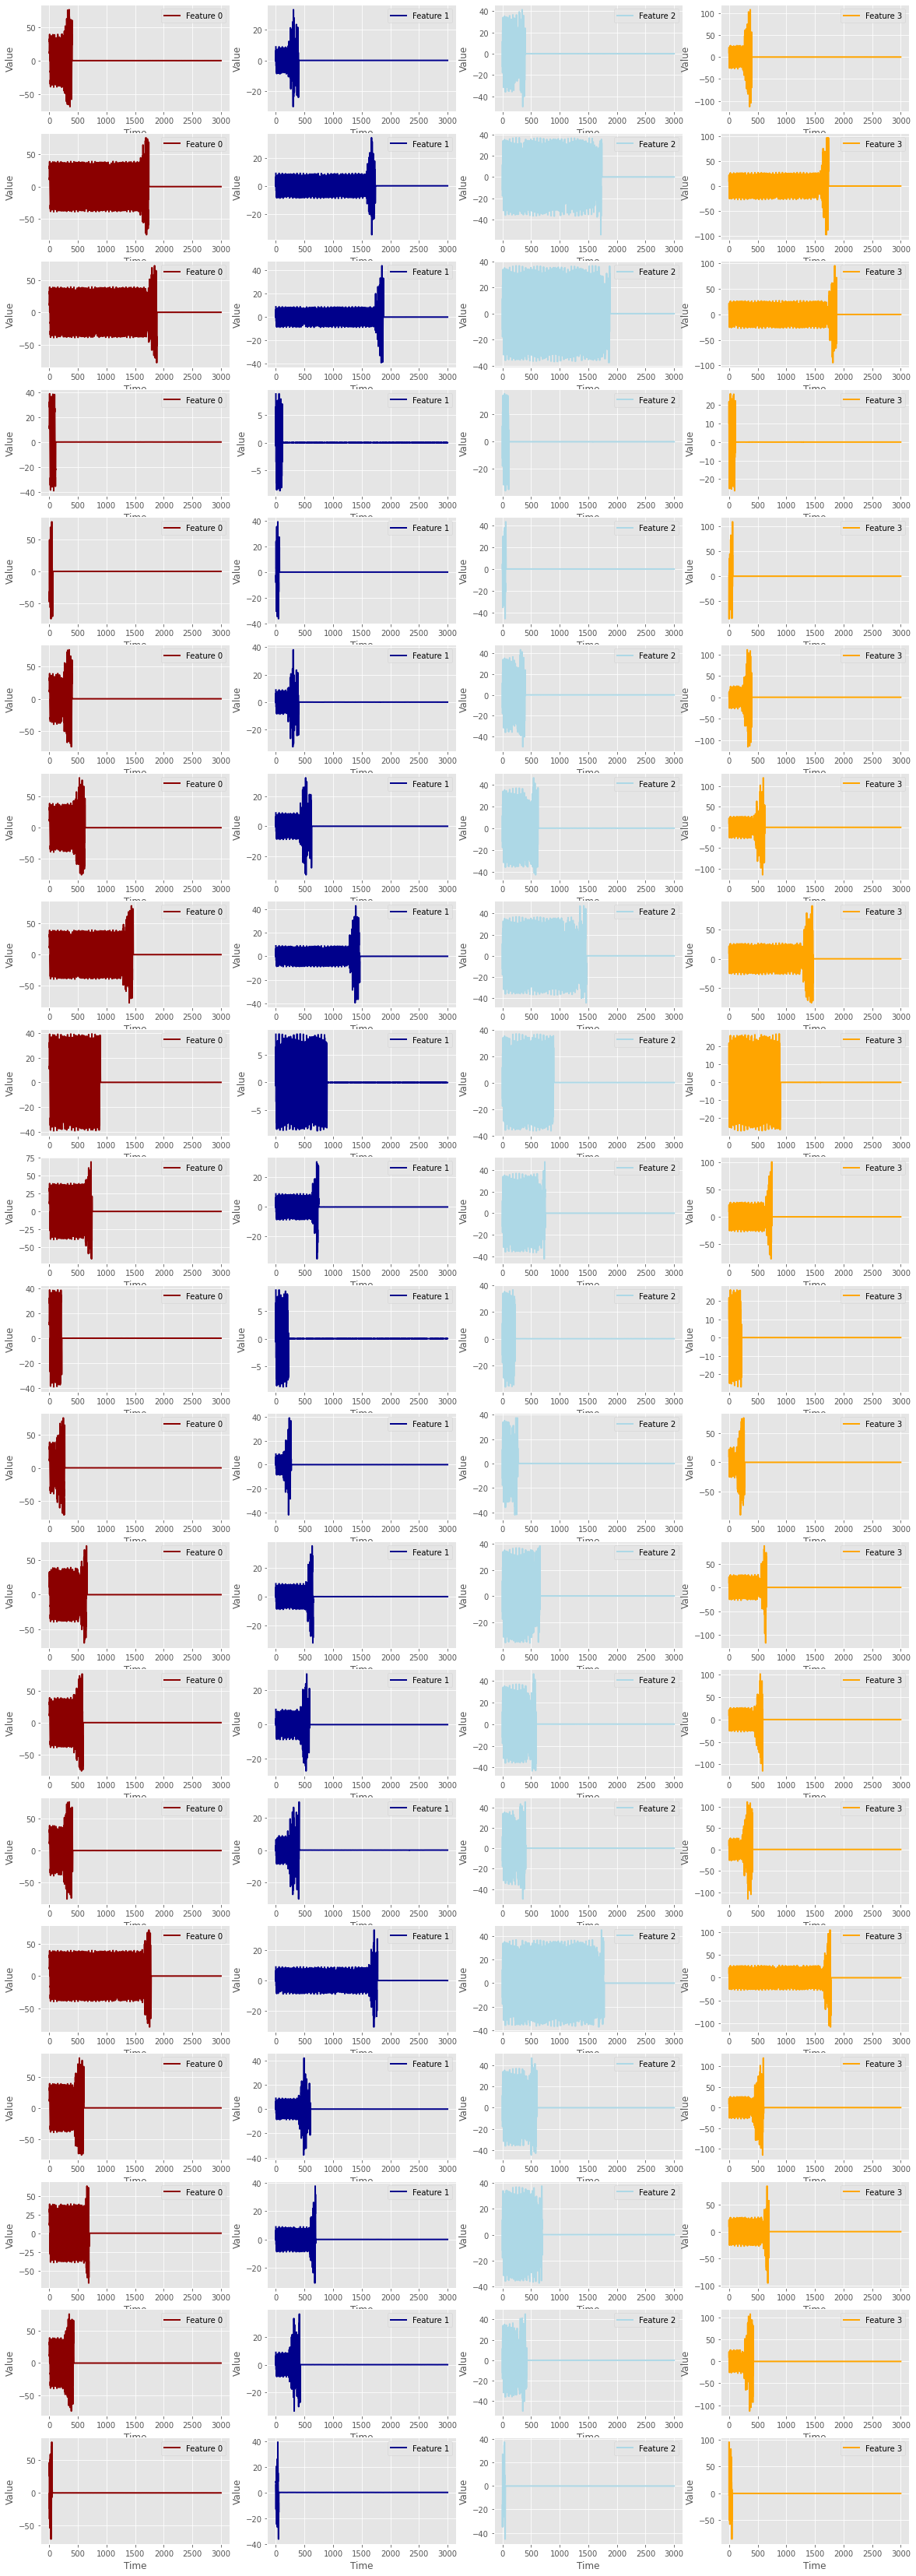

In [54]:
fig, ax = plt.subplots(rows, cols, figsize = (20, 60))
for i in range(0, rows):
    for j in range(0, cols):
        plot_feature(machines[i], j, ax[i, j])
fig.savefig('Figures/all_machines_time_series_cleaned')

## Feature Correlations

Summary:
The timestamps are the same for each machine, and the intervals between measurements are all 8 hours. Therefore we don't expect the time between measurements to be a useful feature. 



# Modeling 

# Conclusions